In [87]:
import torch
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
df = pd.read_csv("../data/OUT20_new_closed_loop_FIXED_2.csv")

In [48]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,PID set value,DMC set value,data set-value,FLU,FRU,FLB,FRB,HL,HR
0,0.000000,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
1,0.100021,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
2,0.200022,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
3,0.300034,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
4,0.400981,3418,3187,3512,2368,2293,950,960,4000,4500,1,500,500,0,0,1000,987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841787,84178.701001,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841788,84178.800978,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841789,84178.900978,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0
841790,84179.000991,3006,3106,3287,2537,2350,45,970,2270,2350,0,500,500,0,0,0,0


In [49]:
df["PID set value"].value_counts()

PID set value
2270    253014
4000    252748
4500    168001
3500     84001
3000     84000
971         28
Name: count, dtype: int64

In [51]:
df["DMC set value"].value_counts()

DMC set value
2350    252972
4000    252002
4500    168789
3500     84001
4300     84000
2270        28
Name: count, dtype: int64

In [52]:
df.drop(["PID set value","DMC set value", "data set-value"], axis=1, inplace=True)

In [53]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,FLU,FRU,FLB,FRB,HL,HR
0,0.000000,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
1,0.100021,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
2,0.200022,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
3,0.300034,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
4,0.400981,3418,3187,3512,2368,2293,950,960,500,500,0,0,1000,987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841787,84178.701001,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841788,84178.800978,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841789,84178.900978,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0
841790,84179.000991,3006,3106,3287,2537,2350,45,970,500,500,0,0,0,0


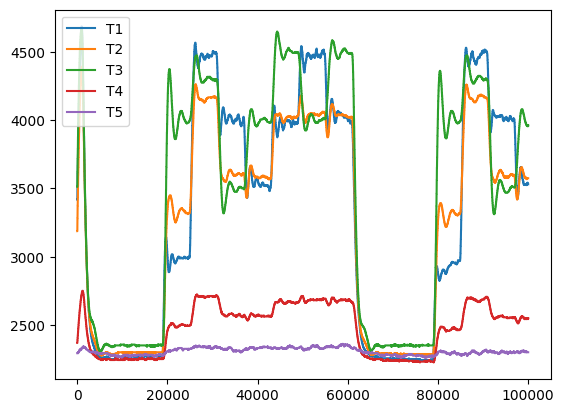

In [76]:
plt.plot(df["T1"][:100000])
plt.plot(df["T2"][:100000])
plt.plot(df["T3"][:100000])
plt.plot(df["T4"][:100000])
plt.plot(df["T5"][:100000])
plt.legend(["T1", "T2", "T3", "T4","T5"], loc="upper left")

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [56]:
class ExperimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


    def __len__(self):
        return len(self.X)

In [57]:
df.keys()

Index(['Timestamp', 'T1', 'T2', 'T3', 'T4', 'T5', 'I', 'V', 'FLU', 'FRU',
       'FLB', 'FRB', 'HL', 'HR'],
      dtype='object')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df[["I","V","FLU" ,"FRU","FLB" ,"FRB", "HL", "HR" ]], df[["T1", "T2", "T3", "T4", "T5"]], test_size = 0.2, random_state = 42)

In [59]:
train_dataset = pd.concat([X_train, y_train], axis =1)
valid_dataset = pd.concat([X_test, y_test], axis = 1)

In [60]:
train_dataset.dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
T1     int64
T2     int64
T3     int64
T4     int64
T5     int64
dtype: object

In [61]:
train_dataset.iloc[:,0:-5].dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
dtype: object

In [62]:
train_dataset = ExperimentDataset(train_dataset.iloc[:,0:-5].values, train_dataset.iloc[:, -5:].values)

# Linear Regression

In [81]:
print(X_train.shape, y_train.shape)

(673433, 8) (673433, 5)


In [80]:
linear_regression_model = LinearRegression()

In [83]:
linear_regression_model.fit(X_train,y_train)

LinearRegression()

In [84]:
linear_regression_model.score(X_train,y_train)

0.6682259588876137

In [89]:
predicted_values = linear_regression_model.predict(X_test)

In [91]:
mse = mean_squared_error(y_test, predicted_values)

In [97]:
mse

np.float64(70374.8157313134)

In [112]:
predicted_values.shape
predicted_values[:, 0]
y_test.values[:, 0]

array([4506, 4481, 3275, ..., 3562, 4050, 2987])

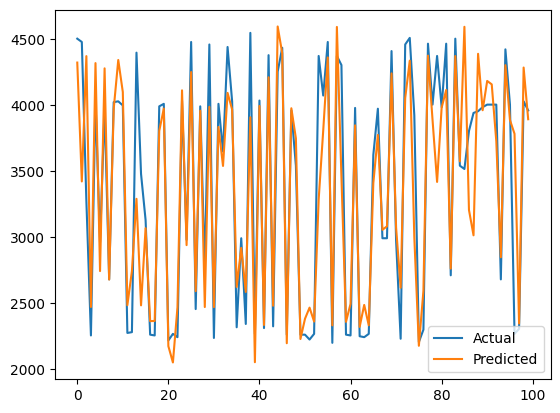

In [116]:
plt.plot(y_test.values[:100,0])
plt.plot(predicted_values[:100,0])
plt.legend(["Actual", "Predicted"])